In [1]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic

from astropy.coordinates import SkyCoord

/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import csv
import pandas
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u


In [3]:
#read in the data from Xue 2208 et al. (~2500 BHB stars)
t = Table.read("BHB2500.txt", format="ascii.cds")

In [4]:
print (t)

    SpName               Name            RAdeg    ...  log(g)  FeH  Type
                                          deg     ... [cm.s2]  [-]      
-------------- ----------------------- ---------- ... ------- ----- ----
51602-0266-125 SDSSJ094317.57-011021.2 145.823196 ...    3.12 -2.03  BHB
51602-0266-397 SDSSJ094138.17+001821.5 145.409058 ...    3.81 -1.97  BHB
51602-0266-634 SDSSJ094840.23+002818.0 147.167633 ...     4.2 -1.27  BHB
51609-0292-102 SDSSJ125223.54-003708.2 193.098083 ...    2.61 -1.96  BHB
51609-0292-329 SDSSJ124641.66+003751.2 191.673569 ...    2.95  -2.0  BHB
51609-0292-351 SDSSJ124449.35+002157.4 191.205612 ...    3.11 -1.43  BHB
51609-0292-582 SDSSJ125254.01+002903.2 193.225037 ...    3.14 -1.66  BHB
51609-0304-219 SDSSJ141723.88-002220.8 214.349503 ...   -9.99 -9.99  BHB
51613-0305-243 SDSSJ142408.24-002930.7 216.034348 ...    3.68 -2.26  BHB
51613-0305-488 SDSSJ142826.28+002915.4 217.109497 ...    2.87 -2.95  BHB
           ...                     ...        ... .

In [6]:
zmin = 20
zmax = 60

In [141]:
# cutting r > 20 & r < 60 kpc stars 
df2=pd.DataFrame()
df2['x']=t['x'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df2['y']=t['y'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df2['z']=t['z'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df2['Vgal']= t['RVgal'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df2['r']= t['r'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
                 

In [143]:
#class for the input of the correlation function 
class Comp:
    def __init__(self,x,y,z,rv):
        '''
        class for the input of the correlation function 
        :param x: x position for the target 
        :param y: y position for the target 
        :param z: z position for the target
        :param rv: radial velocity for the target 
        
        '''

        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
        self.rv = np.array(rv)



In [144]:
k= Comp(df2['x'],df2['y'],df2['z'],df2['Vgal'])

In [15]:
# calculating the correlation function 
def correlated_function(data,w):
    '''
        Function for  calculating the correlation function 
        :param data: data for calculating the correlation function (x,y,z, radial velocity)
        :param w: parameter w in the equation of the correlation function 
        :return: phase-space separation (delta)^2
        
    '''

    dia=[]
    
    for ii in range(0,len(data.rv)): 
        
        
    
        vi = np.repeat(data.rv[ii],len(data.rv))
        xi = np.repeat(data.x[ii],len(data.rv))
        yi = np.repeat(data.y[ii],len(data.rv))
        zi = np.repeat(data.z[ii],len(data.rv))
        
        diffv = w**2*(vi - data.rv)**2
        diffx = (xi - data.x)**2
        diffy = (yi - data.y)**2
        diffz = (zi - data.z)**2
        
        
        
        
        diff = diffv+diffx+diffy+diffz
        #print (diffv, diffx, diffy, diffz,diff)
            
            
        dia.append(diff)
        
        
    diaf = np.array(dia)[np.triu_indices(len(diff),1)]
    return diaf
    
    
        
        
    
    

In [16]:
c = SkyCoord(x=df2['x'], y=df2['y'], z=df2['z'], unit='kpc',representation_type='cartesian')

In [17]:
testcor = correlated_function(k,0.04)

In [21]:
lb_random = Comp(df2['r'],c.galactic.l/u.degree,c.galactic.b/u.degree,df2['Vgal'])

In [22]:
max(lb_random.x)

59.9

In [92]:
def new_set(data,num,num_bins):
    '''
        Function for  calculating the equivalent count for pairs of random points
        :param data: data for calculating the correlation function (x,y,z, radial velocity)
        :param num: number of realizations 
        :param bins: number of bins for the data
        :return: the equivalent count for pairs of random points
        
    '''

    
    new_setl = []
    new_setb = []
    new_r = []
    new_setvi = [] 
    cdf2 = []
    bins = []
    for jj in range(0,num):
        #shuffleing random pairs of (l,b) and (r,v) to get new (l,b,r,v) in order to calculate equivalent count for pairs of random points
        
        index = np.random.choice(len(data.rv), len(data.rv), replace=False)
        index2 = np.random.choice(len(data.x), len(data.x), replace=False)
        new_setvi = data.rv[index]
        new_r = data.x[index] 
        new_setl = data.y[index2] 
        new_setb = data.z[index2]
        c2 = SkyCoord(frame = 'galactic',l=new_setl*u.degree,
             b=new_setb*u.degree, distance=new_r*u.kpc)
        randomf = Comp(c2.cartesian.x, c2.cartesian.y,c2.cartesian.z,new_setvi)
        #calculating the phase-space separation (delta)^2
        rand_cor = correlated_function(randomf,0.04)
        num_bins = num_bins
        #calculating the equivalent count for pairs of random points
        counts2, bin_edges2 = np.histogram (np.sqrt(rand_cor), bins=num_bins, normed=True)
        cdf2.append(np.cumsum (counts2))
        bins.append(bin_edges2)
    
    
   

    
    return bins,cdf2


In [126]:
random_data2bin,random_data2 = new_set(lb_random,1000,70)

/Users/Jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


In [127]:
cdf1 = np.mean(random_data2,axis = 0)
bin_edges1 = np.mean(random_data2bin,axis = 0)

In [128]:
cdf1test =cdf1[bin_edges1[:-1] < 20]
bin_edges1test = bin_edges1[bin_edges1 < 20]

In [129]:
len(cdf1test)

13

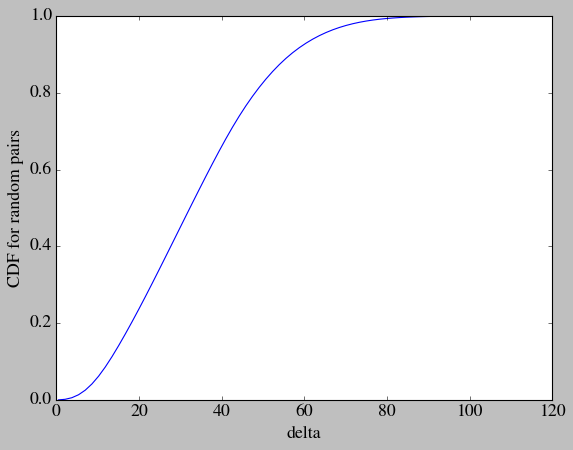

In [130]:
#plotting the cdf for random points
plt.plot (bin_edges1[:-1], cdf1/cdf1[-1])
plt.xlabel('delta')
plt.ylabel('CDF for random pairs')
plt.show()

In [131]:
len(np.array(cdf2/cdf2[-1])[bin_edges2[:-1] < 20])

14

In [132]:
cdf2test =cdf2[bin_edges2[:-1] < 20]
bin_edges2test = bin_edges2[bin_edges2 < 20]

/Users/Jenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  


[611.01     267.8704   262.700496 ... 607.913376  74.591264 429.473056]


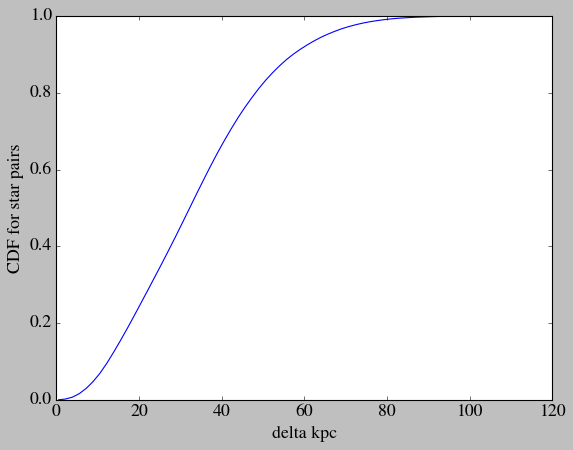

In [136]:
#num_bins = 70
#plotting the cdf for the data
counts2, bin_edges2 = np.histogram (np.sqrt(testcor), bins=70, normed=False)
cdf2 = np.cumsum (counts2)
print (testcor)
plt.plot (bin_edges2[:-1], cdf2/cdf2[-1])
plt.xlabel('delta kpc')
plt.ylabel('CDF for star pairs')
plt.show()

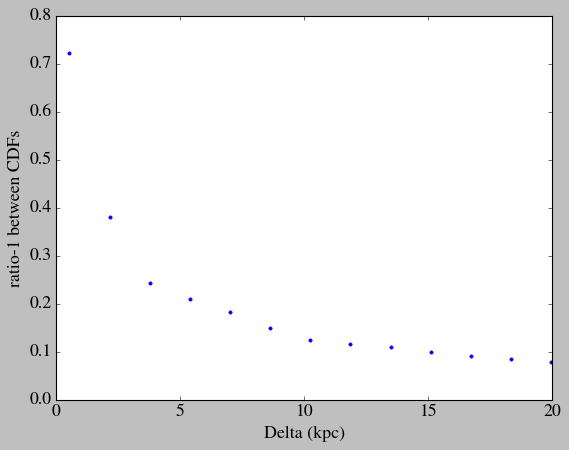

In [140]:
#final result for the correlation function 
plt.plot(bin_edges1[:-1],cdf2/cdf2[-1]/(cdf1/cdf1[-1])-1,'.')
plt.ylabel('ratio-1 between CDFs')
plt.xlabel('Delta (kpc)')
plt.xlim(0,20)
#plt.ylim(0,0.95)
plt.show()